In [147]:
import os
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy

In [267]:
def normalize_points(pts):
    mean = np.mean(pts, axis=0)
    d = np.sqrt(np.sum((pts - mean) ** 2, axis=1)).mean()
    s = np.sqrt(2) / d

    T = np.array([
        [s, 0, -s * mean[0]],
        [0, s, -s * mean[1]],
        [0, 0, 1]
    ])

    pts_h = np.column_stack([pts, np.ones(len(pts))])
    pts_n = (T @ pts_h.T).T

    return pts_n[:, :2], T

In [197]:
def find_homography(world_points: np.ndarray, image_points: np.ndarray):
    n = world_points.shape[0]
    A = np.zeros((2 * n, 9))

    for i in range(n):
        X, Y = world_points[i]
        u, v = image_points[i]

        A[2 * i, :] = [-X, -Y, -1, 0, 0, 0, X * u, Y * u, u]
        A[2 * i + 1, :] = [0, 0, 0, -X, -Y, -1, X * v, Y * v, v]

    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    return H

In [120]:
def get_b(H, i, j):
    return np.array([
        H[0, i] * H[0, j],
        H[0, i] * H[1, j] + H[1, i] * H[0, j],
        H[1, i] * H[1, j],
        H[2, i] * H[0, j] + H[0, i] * H[2, j],
        H[2, i] * H[1, j] + H[1, i] * H[2, j],
        H[2, i] * H[2, j]
    ])

In [173]:
images_dir = './images'
images = []
for i in os.listdir(images_dir):
    print(i)
    images.append(cv2.imread(f'{images_dir}/{i}', cv2.IMREAD_GRAYSCALE))

1766081758.png
1766081763.png
1766081766.png
1766081769.png
1766081772.png
1766081775.png
1766081778.png
1766081782.png
1766081784.png
1766081788.png


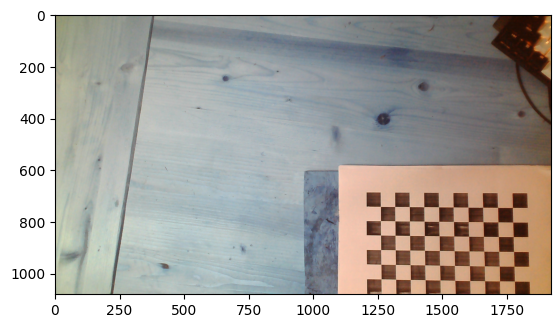

In [104]:
plt.imshow(images[0])

In [278]:
pattern_w = 10
pattern_h = 6
square_size = 20
world_points = []
for y in range(pattern_h):
    for x in range(pattern_w):
        world_points.append([x, y])
world_points = np.array(world_points, dtype=np.float64) * square_size
wp_n, Tw = normalize_points(world_points)

In [279]:
world_points

array([[  0.,   0.],
       [ 20.,   0.],
       [ 40.,   0.],
       [ 60.,   0.],
       [ 80.,   0.],
       [100.,   0.],
       [120.,   0.],
       [140.,   0.],
       [160.,   0.],
       [180.,   0.],
       [  0.,  20.],
       [ 20.,  20.],
       [ 40.,  20.],
       [ 60.,  20.],
       [ 80.,  20.],
       [100.,  20.],
       [120.,  20.],
       [140.,  20.],
       [160.,  20.],
       [180.,  20.],
       [  0.,  40.],
       [ 20.,  40.],
       [ 40.,  40.],
       [ 60.,  40.],
       [ 80.,  40.],
       [100.,  40.],
       [120.,  40.],
       [140.,  40.],
       [160.,  40.],
       [180.,  40.],
       [  0.,  60.],
       [ 20.,  60.],
       [ 40.,  60.],
       [ 60.,  60.],
       [ 80.,  60.],
       [100.,  60.],
       [120.,  60.],
       [140.,  60.],
       [160.,  60.],
       [180.,  60.],
       [  0.,  80.],
       [ 20.,  80.],
       [ 40.,  80.],
       [ 60.,  80.],
       [ 80.,  80.],
       [100.,  80.],
       [120.,  80.],
       [140.,

In [280]:
from copy import copy

i = copy(images[0])
# cv2.drawChessboardCorners(i, (10, 6), image_points, True)
cv2.imshow('test', i)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [281]:
V = []

for image in images:
    ret, corners = cv2.findChessboardCorners(image, (pattern_w, pattern_h))

    corners = cv2.cornerSubPix(
        image,
        corners,
        (11, 11),
        (-1, -1),
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

    image_points = corners.reshape(-1, 2)
    ip_n, Ti = normalize_points(image_points)
    Hn = find_homography(wp_n, ip_n)
    H = np.linalg.inv(Ti) @ Hn @ Tw
    H /= H[2, 2]
    
    V.append(get_b(H, 0, 1))
    V.append(get_b(H, 0, 0) - get_b(H, 1, 1))


In [282]:
V

[array([-3.06133259e-01,  7.25152787e+00, -8.69276865e-02, -2.95842919e-04,
        -2.05317678e-04,  8.78429432e-09]),
 array([ 7.26210797e+00,  4.35476680e-01, -7.21977708e+00, -4.45149283e-04,
         6.12097559e-04, -6.71158025e-09]),
 array([-5.36239539e-01,  7.07003952e+00,  8.47455474e-02, -2.94709531e-04,
        -2.45729122e-04,  1.07046433e-08]),
 array([ 7.04311220e+00,  1.24104688e+00, -7.06820844e+00, -5.31851269e-04,
         6.19650581e-04, -5.55127842e-09]),
 array([-9.20753926e-01,  6.64808273e+00,  4.01017656e-01, -2.75770588e-04,
        -3.24005494e-04,  1.44541284e-08]),
 array([ 6.50896994e+00,  2.65403125e+00, -6.74653413e+00, -6.92098343e-04,
         6.05561773e-04, -1.46477398e-09]),
 array([-6.62784628e-01,  6.48130276e+00,  1.95829508e-01, -2.67916561e-04,
        -2.54852043e-04,  1.10878855e-08]),
 array([ 6.40867863e+00,  1.72080452e+00, -6.52024652e+00, -5.50147765e-04,
         5.73471786e-04, -3.98040917e-09]),
 array([-1.87579281e-01,  6.52487456e+00

In [283]:
_, S, Vm = np.linalg.svd(np.array(V))
b = Vm[-1]
b = b / np.linalg.norm(b)
if b[0] < 0:
    b = -b

B11, B12, B22, B13, B23, B33 = b

In [284]:
np.linalg.det(B)

np.float64(-4.695138316371759e-21)

In [285]:
v0 = (B12 * B13 - B11 * B23) / (B11 * B22 - B12 ** 2)
v0

np.float64(-14288.537851072542)

In [286]:
lambda_ = B33 - (B13 ** 2 + v0 * (B12 * B13 - B11 * B23)) / B11
lambda_

np.float64(0.025152433703074406)

In [287]:
fx = np.sqrt(lambda_ / B11)
fy = np.sqrt(lambda_ * B11 / (B11 * B22 - B12 ** 2))

In [288]:
print(B11)
print(B11 * B22 - B12 ** 2)

9.505321500262306e-10
4.1712261953696895e-19


In [289]:
print(fx)
print(fy)

5144.066817924008
7570.795951448559
